# PFAS Toolbox - PFAS Concentration Relationship to Urban and Agricultural

## Import Libaries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import chardet
import seaborn as sns
import openpyxl 
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FixedLocator, FixedFormatter
import scipy.stats as stats
from matplotlib.ticker import AutoMinorLocator
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import LogFormatter

## Data Import and Export

In [1]:
def read_excel_sheet(excel_file, sheet_name):
    """
    Read a specific sheet from an Excel file into a DataFrame.

    Args:
        excel_file (str): The path to the Excel file.
        sheet_name (str): The name of the sheet to read.

    Returns:
        pd.DataFrame or None: A DataFrame containing the sheet data or None if the sheet is not found.
    """
    try:
        # Load the specified sheet from the Excel file into a DataFrame
        df = pd.read_excel(excel_file, sheet_name=sheet_name, skiprows=1)
        return df
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None

In [2]:
def dfs_to_excel(dfs, filename):
    """
    Write an array of dataframes to separate tabs in an Excel file.
    
    Parameters:
    - dfs: A dictionary where keys are the tab names and values are the DataFrames to write.
    - filename: The name of the Excel file to write to.
    """
    # Create a Pandas Excel writer using XlsxWriter as the engine.
    with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        for tab_name, df in dfs.items():
            # Write each dataframe to a separate sheet
            df.to_excel(writer, sheet_name=tab_name)
    
    print(f"File '{filename}' has been written with {len(dfs)} tabs.")

In [5]:
# Example usage:

#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'U:/Research_and_Innovation/_ModellingGroupProjects/PFAS Investigations/Data and analysis/Database as of 01-15-2025.xlsm'
#Specify sheet name
sheet_name = 'PFAS Database'

#Call data import function
data_df = read_excel_sheet(excel_file_path, sheet_name)


## Figure Default Settings

In [6]:
# Set default tick label size
plt.rcParams['xtick.labelsize'] = 26
plt.rcParams['ytick.labelsize'] = 26

# Set default font size for title, labels, and legend
plt.rcParams['axes.titlesize'] = 34  # Set the font size for plot titles
plt.rcParams['axes.labelsize'] = 28  # Set the font size for axis labels
plt.rcParams['legend.fontsize'] = 24  # Set the font size for legend
plt.rcParams['legend.title_fontsize'] = 24  # Set the font size for legend

# Set default font family to Arial
plt.rcParams['font.family'] = 'Arial'

# Set default font type for plot titles to bold
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

## Import Other Data

In [7]:
# Import PFAS Attributes

#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'U:/Research_and_Innovation/_ModellingGroupProjects/PFAS Investigations/Data and analysis/Old Databases and Spreadsheets/Database as of 03-25-2024.xlsm'
#Specify sheet name
sheet_name = 'PFAS Attributes'

df_PFAS_Attributes = pd.read_excel(excel_file_path, sheet_name=sheet_name)

In [8]:
# Create a dictionary mapping PFAS Compounds to their corresponding Abbreviation (No need to change)
pfas_mapping = dict(zip(df_PFAS_Attributes['Database'], df_PFAS_Attributes['Abbrev']))

## PFAS Concentrations Relationship to Urban and Ag

### Functions

In [9]:
def create_filtered_pivot_table(data_df, qual_summary_filter, start_date, end_date, type_filter, pfas_compound_filter, sample_location_filter):
    """
    Create a pivot table from the given dataframe with specified filters and date range.

    Args:
        data_df (pd.DataFrame): The input dataframe.
        qual_summary_filter (list): Filter values for 'Qual Summary (Grade for filtering)'.
        start_date (str): Start date for filtering 'Sample Date'.
        end_date (str): End date for filtering 'Sample Date'.
        type_filter (list): Filter values for 'Type'.
        pfas_compound_filter (list): Filter values for 'PFAS Compound'.
        sample_location_filter (list): Filter values for 'Sample Location'.

    Returns:
        pd.DataFrame: The resulting pivot table.
    """
    # Convert 'Sample Date' to datetime
    data_df['Sample Date'] = pd.to_datetime(data_df['Sample Date'])

    # Apply filters based on user-provided values
    filtered_data = data_df[
        data_df['Qual Summary (Grade for filtering)'].isin(qual_summary_filter) &
        (data_df['Sample Date'] >= pd.to_datetime(start_date)) &
        (data_df['Sample Date'] <= pd.to_datetime(end_date)) &
        data_df['Type'].isin(type_filter) &
        data_df['PFAS Compound'].isin(pfas_compound_filter) &
        data_df['Sample Location'].isin(sample_location_filter)
    ]

    # Create the pivot table
    pivot_table = pd.pivot_table(
        filtered_data,
        values='Quant Incl Estimates Incl Qual Flags',
        index='PFAS Compound',
        columns=['Type', 'Sample Location'],
        aggfunc='mean'
    )

    return pivot_table

In [10]:
def plot_correlation_heatmap(data_df, fig_size=(12,12)):
    """
    Plot a heatmap of the Pearson correlation coefficients of a DataFrame.

    Args:
        data_df (pd.DataFrame): The input dataframe with numerical attributes.
        fig_size (tuple): The size of the figure (width, height).
    """
    # Calculate the Pearson correlation coefficients
    correlation_matrix = data_df.corr()

    # Create the heatmap
    plt.figure(figsize=fig_size)
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)

    # Add titles and labels as needed
    plt.title('Pearson Correlation Heatmap')
    plt.xlabel('Attributes')
    plt.ylabel('Attributes')

    # Show the plot
    plt.show()

In [46]:
def plot_scatter(data_df, column_x, column_y, fig_size=(10, 8), 
                 title_fontsize=20, axis_label_fontsize=16, tick_label_fontsize=14):
    """
    Create a scatter plot for two specified columns from a DataFrame with enhanced styling and
    statistical annotations.

    Args:
        data_df (pd.DataFrame): The input dataframe.
        column_x (str): The name of the column for the x-axis.
        column_y (str): The name of the column for the y-axis.
        fig_size (tuple): The size of the figure (width, height).
        title_fontsize (int): Font size for the chart title.
        axis_label_fontsize (int): Font size for the axis labels.
        tick_label_fontsize (int): Font size for the tick labels.
    """
    font_bold = FontProperties(family='Arial', weight='bold')
    
    fig, ax = plt.subplots(figsize=fig_size)
    scatter = ax.scatter(data_df[column_x]*100, data_df[column_y])

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(data_df[column_x]*100, data_df[column_y])
    r_squared = r_value**2

    # Adding linear regression line to the scatter plot
    ax.plot(data_df[column_x]*100, intercept + slope * data_df[column_x]*100, color='red')

    # Adding titles and labels with custom fonts
    ax.set_title(f'Scatter Plot of {column_x} vs {column_y}', fontsize=title_fontsize)
    ax.set_xlabel(column_x, fontsize=axis_label_fontsize, fontproperties=font_bold)
    ax.set_ylabel(column_y, fontsize=axis_label_fontsize, fontproperties=font_bold)

    # Annotation for R-squared and p-value
    ax.annotate(f'R² = {r_squared:.3f}\np-value = {p_value:.3g}', xy=(0.05, 0.95), xycoords='axes fraction',
                verticalalignment='top', horizontalalignment='left', 
                fontsize=22, bbox=dict(boxstyle="round, pad=0.3", edgecolor='red', facecolor='yellow', alpha=0.5))


    # Setting tick label sizes
    ax.tick_params(axis='both', which='major', labelsize=tick_label_fontsize)

    plt.tight_layout()
    plt.show()

### Filters and Settings

In [52]:
#qual_summary_filter (list): Filter values for 'Qual Summary (Grade for filtering)'.
qual_summary_filter=filter_qual_summary = ['Good','Probably Ok','','Probably ok','probably ok']
# Specify start_date (str, optional): Start date for the date range filter (default is None).
start_date='2023-06-01'
#Specify end_date (str, optional): End date for the date range filter (default is None).
end_date='2023-06-30'

start_date='2024-02-01'
#Specify end_date (str, optional): End date for the date range filter (default is None).
end_date='2024-02-29'

start_date='2024-04-01'
#Specify end_date (str, optional): End date for the date range filter (default is None).
end_date='2024-04-30'

#type_filter (list): Filter values for 'Type'.
type_filter=['Ambient','Urban Creek']

ambient_locations= ['TR @ Jurgens', 'TR @ Cherry Grove', 'TR @ Fernhill',
       'TR @ Boones Ferry', 'TR @ Golf Course', 'TR @ Farmington',
       'Fanno at Durham Rd', 'TR @ Rood Br', 'Rock @ Brookwood',
       'Dairy @ Hwy 8', 'Chicken @ Sholls-Sherwood',
       'Scoggins Below Hagg', 'Gales @ Stringtown', 'McKay @ Padgett',
       'Beaverton @ Cornelius','Rock @ River Rd','Rock @ East Main St',
       'Rock @ NE Cornelius Pass Rd','Rock @ NW Rock Creek Blvd',
       'Rock @ NW Old Cornelius Pass Rd','Fanno @ Durham Park','Fanno @ SW Bonita Rd',
       'Fanno @ SW Grant Ave','Fanno @ SW North Dakota St','Fanno @ SW 56th Ave',
       'Fanno @ Bohmann','Ash Creek @ Greenburg','Dawson @ Brookwood'
       ]

#pfas_compound_filter (list): Filter values for 'PFAS Compound'.
pfas_compound_filter=data_df['PFAS Compound'].unique()
#sample_location_filter (list): Filter values for 'Sample Location'.
sample_location_filter =ambient_locations

### Create Pivot for Average Concentrations

#### Create Pivot for Average Concentrations - One Datapoint per Sampling Event

In [34]:
#June 2023
# Specify start_date (str, optional): Start date for the date range filter (default is None).
start_date='2023-06-01'

#Specify end_date (str, optional): End date for the date range filter (default is None).
end_date='2023-06-30'
pivot_table_2023=create_filtered_pivot_table(data_df=data_df, qual_summary_filter=qual_summary_filter, start_date=start_date, end_date=end_date, type_filter=type_filter,
                                         pfas_compound_filter=pfas_compound_filter, sample_location_filter=sample_location_filter)

# Rename the index of data_df using the mapping (No need to change)
pivot_table_2023.index = pivot_table_2023.index.map(pfas_mapping)

pivot_table_2023=pivot_table_2023.transpose().reset_index(level=0, drop=True)

# Add a column to sum all PFAS concentrations per location
pivot_table_2023['PFAS Total'] = pivot_table_2023.sum(axis=1)

#pivot_table_2023.index = pivot_table_2023.index.map(lambda x: str(x) + '_2023')
pivot_table_2023


PFAS Compound,10:2FTS,11Cl-PF3OUdS,4:2FTS,6:2FTS,8:2FTS,9Cl-PF3ONS,ADONA,HFPO-DA,NEtFOSA,NEtFOSAA,...,PFODA,FOSA,PFOS,PFOA,PFPeS,PFPeA,PFTeDA,PFTrDA,PFUnA,PFAS Total
Sample Location,,,,,,,,,,,,,,,,,,,,,
Chicken @ Sholls-Sherwood,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.32,1.60,1.20,0.00,1.50,0.0,0.0,0.0,8.21
Dairy @ Hwy 8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.31,0.99,0.88,0.00,0.68,0.0,0.0,0.0,3.98
Fanno at Durham Rd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.38,14.00,7.30,0.58,6.20,0.0,0.0,0.0,54.36
Gales @ Stringtown,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.36,0.00,0.34,0.00,0.00,0.0,0.0,0.0,0.70
McKay @ Padgett,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.35,1.50,2.10,0.00,2.00,0.0,0.0,0.0,12.62
Rock @ Brookwood,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.37,9.70,5.00,0.38,5.90,0.0,0.0,0.0,42.95
Scoggins Below Hagg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00
TR @ Boones Ferry,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.32,2.70,2.40,0.00,3.40,0.0,0.0,0.0,22.59
TR @ Cherry Grove,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.47,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.72


In [56]:
start_date='2024-02-01'
#Specify end_date (str, optional): End date for the date range filter (default is None).
end_date='2024-02-29'
pivot_table_Feb2024=create_filtered_pivot_table(data_df=data_df, qual_summary_filter=qual_summary_filter, start_date=start_date, end_date=end_date, type_filter=type_filter,
                                         pfas_compound_filter=pfas_compound_filter, sample_location_filter=sample_location_filter)

# Rename the index of data_df using the mapping (No need to change)
pivot_table_Feb2024.index = pivot_table_Feb2024.index.map(pfas_mapping)

pivot_table_Feb2024=pivot_table_Feb2024.transpose().reset_index(level=0, drop=True)

# Add a column to sum all PFAS concentrations per location
pivot_table_Feb2024['PFAS Total'] = pivot_table_Feb2024.sum(axis=1)

#pivot_table_2024.index = pivot_table_2024.index.map(lambda x: str(x) + '_2024')
pivot_table_Feb2024

PFAS Compound,11Cl-PF3OUdS,3:3FTCA,4:2FTS,5:3FTCA,6:2FTS,7:3FTCA,8:2FTS,9Cl-PF3ONS,ADONA,HFPO-DA,...,PFNA,FOSA,PFOS,PFOA,PFPeS,PFPeA,PFTeDA,PFTrDA,PFUnA,PFAS Total
Sample Location,,,,,,,,,,,,,,,,,,,,,
Chicken @ Sholls-Sherwood,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.10,0.0,1.60,1.60,0.00,1.4,0.0,0.0,0.0,9.07
Dairy @ Hwy 8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.88,1.00,0.00,0.0,0.0,0.0,0.0,2.17
Fanno at Durham Rd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.00,0.0,9.90,0.00,0.56,5.8,0.0,0.0,0.0,37.93
Gales @ Stringtown,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00
McKay @ Padgett,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,1.10,2.80,0.00,1.3,0.0,0.0,0.0,11.20
Rock @ Brookwood,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.10,0.0,8.30,4.90,0.00,4.1,0.0,0.0,0.0,33.66
Scoggins Below Hagg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00
TR @ Boones Ferry,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,2.10,1.40,0.00,1.4,0.0,0.0,0.0,8.86
TR @ Cherry Grove,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00


In [36]:
start_date='2024-04-01'
#Specify end_date (str, optional): End date for the date range filter (default is None).
end_date='2024-04-30'
pivot_table_Apr2024=create_filtered_pivot_table(data_df=data_df, qual_summary_filter=qual_summary_filter, start_date=start_date, end_date=end_date, type_filter=type_filter,
                                         pfas_compound_filter=pfas_compound_filter, sample_location_filter=sample_location_filter)

# Rename the index of data_df using the mapping (No need to change)
pivot_table_Apr2024.index = pivot_table_Apr2024.index.map(pfas_mapping)

pivot_table_Apr2024=pivot_table_Apr2024.transpose().reset_index(level=0, drop=True)

# Add a column to sum all PFAS concentrations per location
pivot_table_Apr2024['PFAS Total'] = pivot_table_Apr2024.sum(axis=1)

#pivot_table_2024.index = pivot_table_2024.index.map(lambda x: str(x) + '_2024')
pivot_table_Apr2024

PFAS Compound,11Cl-PF3OUdS,3:3FTCA,4:2FTS,5:3FTCA,6:2FTS,7:3FTCA,8:2FTS,9Cl-PF3ONS,ADONA,HFPO-DA,...,PFNA,FOSA,PFOS,PFOA,PFPeS,PFPeA,PFTeDA,PFTrDA,PFUnA,PFAS Total
Sample Location,,,,,,,,,,,,,,,,,,,,,
Beaverton @ Cornelius,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.40,0.0,11.00,7.60,0.73,6.0,0.0,0.0,0.0,51.76
Chicken @ Sholls-Sherwood,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.20,0.0,1.20,1.50,0.00,0.0,0.0,0.0,0.0,6.90
Dairy @ Hwy 8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.58,0.69,0.00,0.0,0.0,0.0,0.0,1.58
Dawson @ Brookwood,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.10,0.0,6.60,4.30,0.77,8.0,0.0,0.0,0.0,53.87
Fanno at Durham Rd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.99,0.0,12.00,7.40,0.58,5.5,0.0,0.0,0.0,47.85
Gales @ Stringtown,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00
McKay @ Padgett,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.88,2.70,0.00,1.9,0.0,0.0,0.0,10.87
Rock @ Brookwood,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.97,0.0,7.50,4.90,0.00,4.6,0.0,0.0,0.0,34.96
Scoggins Below Hagg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00


In [37]:
# Concatenate the DataFrames
pivot_table = pd.concat([pivot_table_2023, pivot_table_Feb2024,pivot_table_Apr2024], ignore_index=False)
pivot_table

PFAS Compound,10:2FTS,11Cl-PF3OUdS,4:2FTS,6:2FTS,8:2FTS,9Cl-PF3ONS,ADONA,HFPO-DA,NEtFOSA,NEtFOSAA,...,PFTrDA,PFUnA,PFAS Total,3:3FTCA,5:3FTCA,7:3FTCA,NFDHA,PFEESA,PFMBA,PFMPA
Sample Location,,,,,,,,,,,,,,,,,,,,,
Chicken @ Sholls-Sherwood,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,8.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dairy @ Hwy 8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fanno at Durham Rd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,54.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gales @ Stringtown,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN
McKay @ Padgett,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,12.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Fanno @ SW North Dakota St,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,51.13,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Rock @ East Main St,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,21.12,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Rock @ NE Cornelius Pass Rd,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,18.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Create Pivot for Average Concentrations - One Datapoint per Sampling Location

In [58]:
#June 2023
# Specify start_date (str, optional): Start date for the date range filter (default is None).
start_date='2023-06-01'

#Specify end_date (str, optional): End date for the date range filter (default is None).
end_date='2024-12-30'
pivot_table=create_filtered_pivot_table(data_df=data_df, qual_summary_filter=qual_summary_filter, start_date=start_date, end_date=end_date, type_filter=type_filter,
                                         pfas_compound_filter=pfas_compound_filter, sample_location_filter=sample_location_filter)

# Rename the index of data_df using the mapping (No need to change)
pivot_table.index = pivot_table.index.map(pfas_mapping)

pivot_table=pivot_table.transpose().reset_index(level=0, drop=True)

# Add a column to sum all PFAS concentrations per location
pivot_table['PFAS Total'] = pivot_table.sum(axis=1)

#pivot_table_2023.index = pivot_table_2023.index.map(lambda x: str(x) + '_2023')
pivot_table

PFAS Compound,10:2FTS,11Cl-PF3OUdS,3:3FTCA,4:2FTS,5:3FTCA,6:2FTS,7:3FTCA,8:2FTS,9Cl-PF3ONS,ADONA,...,PFODA,FOSA,PFOS,PFOA,PFPeS,PFPeA,PFTeDA,PFTrDA,PFUnA,PFAS Total
Sample Location,,,,,,,,,,,,,,,,,,,,,
Beaverton @ Cornelius,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.000000,11.000000,7.600000,0.730000,6.000000,0.0,0.0,0.0,51.760000
Chicken @ Sholls-Sherwood,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.106667,1.466667,1.433333,0.000000,0.966667,0.0,0.0,0.0,8.060000
Dairy @ Hwy 8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.103333,0.816667,0.856667,0.000000,0.226667,0.0,0.0,0.0,2.576667
Dawson @ Brookwood,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.000000,6.600000,4.300000,0.770000,8.000000,0.0,0.0,0.0,53.870000
Fanno at Durham Rd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.095000,11.475000,5.600000,0.572500,5.650000,0.0,0.0,0.0,46.027500
Gales @ Stringtown,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.120000,0.000000,0.113333,0.000000,0.000000,0.0,0.0,0.0,0.233333
McKay @ Padgett,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.116667,1.160000,2.533333,0.000000,1.733333,0.0,0.0,0.0,11.563333
Rock @ Brookwood,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.123333,8.500000,4.933333,0.126667,4.866667,0.0,0.0,0.0,37.190000
Scoggins Below Hagg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


### Import Sample Sites Data

In [59]:
# Example usage:

#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'U:/Research_and_Innovation/_ModellingGroupProjects/PFAS Investigations/Data and analysis/Database as of 01-15-2025.xlsm'
#Specify sheet name
sheet_name = 'June 2023 Ambient Flows'

#Call data import function
sites_df = read_excel_sheet(excel_file_path, sheet_name)

#drop multiple columns by name
sites_df.drop(['Unnamed: 0', 'June 2023 Flow (cfs)','Source Notes'], axis=1, inplace=True)

# setting 	WRRF Effluents for Ambient as index column
sites_df.set_index("WRRF Effluents for Ambient", inplace = True)
sites_df.head()

,Area (acres),Forest Acres,Ag Acres,Urban Acres,Imp Acres,% Forest,% Ag,% Urban,% Imp,Upstream WRRFs,Upstream Tribs
WRRF Effluents for Ambient,,,,,,,,,,,
TR @ Cherry Grove,25461.924347,21549.382949,3661.284345,251.257053,477.086571,0.846338,0.143794,0.009868,0.018737,NaN,NaN
Scoggins Below Hagg,4951.660999,3194.021900,1547.320000,210.319099,211.557982,0.645041,0.312485,0.042474,0.042725,NaN,NaN
Gales @ Stringtown,43724.166616,36137.866805,7085.507520,500.792292,773.669939,0.826496,0.162050,0.011453,0.017694,NaN,NaN
TR @ Fernhill,136872.565188,98254.411496,34653.435124,3964.718568,3537.833545,0.717853,0.253180,0.028966,0.025848,NaN,Scoggins + Gales
Forest Grove Effluent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Merge PFAS Compound Concentrations and Sample Locations Information based on Sample Locations

In [60]:
# Merge dataframes
merged_df = pd.merge(pivot_table, sites_df, left_index=True, right_index=True, how='inner')
merged_df

,10:2FTS,11Cl-PF3OUdS,3:3FTCA,4:2FTS,5:3FTCA,6:2FTS,7:3FTCA,8:2FTS,9Cl-PF3ONS,ADONA,...,Forest Acres,Ag Acres,Urban Acres,Imp Acres,% Forest,% Ag,% Urban,% Imp,Upstream WRRFs,Upstream Tribs
Sample Location,,,,,,,,,,,,,,,,,,,,,
Ash Creek @ Greenburg,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,85.000000,233.000000,1975.000000,872.000000,0.040000,0.100000,0.860000,0.380000,NaN,NaN
Beaverton @ Cornelius,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2057.000000,2748.000000,18946.000000,10385.000000,0.090000,0.120000,0.800000,0.440000,NaN,NaN
Chicken @ Sholls-Sherwood,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3200.882770,4382.362286,1960.730425,1046.303633,0.335383,0.459176,0.205442,0.109630,NaN,NaN
Dairy @ Hwy 8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,77938.000606,52950.005912,7594.646741,5401.105391,0.562800,0.382358,0.054842,0.039002,NaN,NaN
Dawson @ Brookwood,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,29.000000,423.000000,2205.000000,1431.000000,0.010000,0.160000,0.830000,0.540000,NaN,NaN
Fanno @ Bohmann,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,562.000000,1027.000000,3774.000000,1651.000000,0.100000,0.190000,0.700000,0.310000,NaN,NaN
Fanno @ Durham Park,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1275.000000,2456.000000,16011.000000,8185.000000,0.060000,0.120000,0.810000,0.410000,NaN,NaN
Fanno @ SW 56th Ave,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,115.000000,253.000000,1171.000000,482.000000,0.070000,0.160000,0.760000,0.310000,NaN,NaN
Fanno @ SW Bonita Rd,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1117.000000,2282.000000,14161.000000,7121.000000,0.060000,0.130000,0.810000,0.410000,NaN,NaN


### Create Scatter Plot to See Relationship

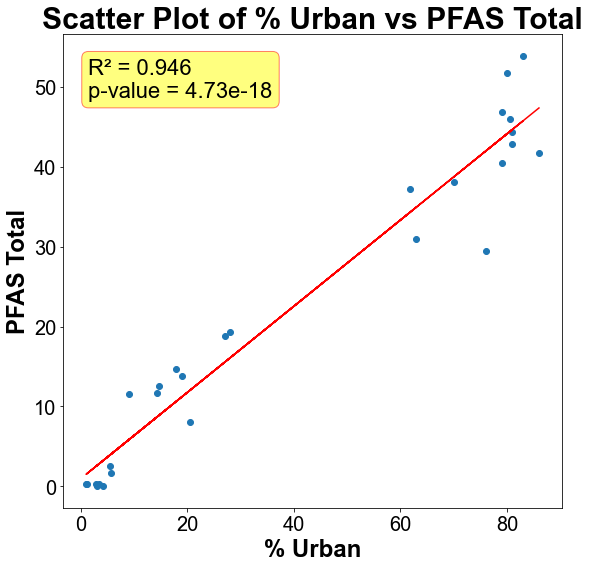

In [61]:
plot_scatter(merged_df,  '% Urban','PFAS Total',fig_size=(8,8),title_fontsize=30, axis_label_fontsize=24, tick_label_fontsize=20)

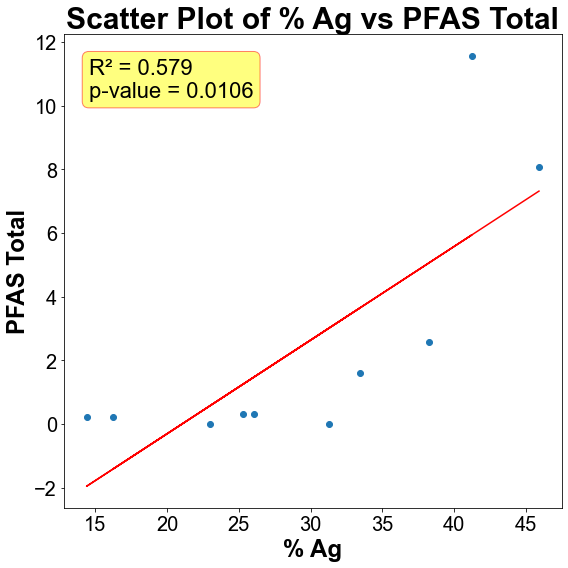

In [63]:
plot_scatter(merged_df.loc[['Chicken @ Sholls-Sherwood','Dairy @ Hwy 8','Gales @ Stringtown', 'McKay @ Padgett','Scoggins Below Hagg', 'TR @ Cherry Grove',
               'TR @ Fernhill', 'TR @ Golf Course','TR @ Rood Br','Rock @ NW Old Cornelius Pass Rd']],  '% Ag','PFAS Total',fig_size=(8,8),title_fontsize=30, axis_label_fontsize=24, tick_label_fontsize=20)